In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os

In [2]:
# from tensorflow import keras

In [3]:
import tensorflow as tf

In [4]:
# tf.compat.v1.enable_eager_execution()

In [5]:
path = os.path.join("..", "dane", "clean", "test.csv")

df = pd.read_csv(path)
df.head()

,index,date,time,open,high,low,last,volume,# of trades,ohlc avg,...,bottom band,obv length,dayfraction,seconds,timestamp_str,timestamp_ns,dayofweek,daysinmonth,weekno,monthfraction
0,8895,2023-6-15,00:01:10.517003,4418.75,4418.75,4417.00,4417.25,600,482,4417.94,...,4417.93,600,0.000816,70.517003,2023-06-15 00:01:10.517003,1686787270517003000,3,30,24,0.5
1,8896,2023-6-15,00:05:33.982002,4417.25,4417.75,4416.50,4416.50,600,466,4417.00,...,4417.73,600,0.003866,333.982002,2023-06-15 00:05:33.982002,1686787533982002000,3,30,24,0.5
2,8897,2023-6-15,00:12:19.360000,4416.50,4418.25,4416.25,4418.25,600,458,4417.31,...,4417.65,600,0.008557,739.360000,2023-06-15 00:12:19.360000,1686787939360000000,3,30,24,0.5
3,8898,2023-6-15,00:18:57.236000,4418.25,4418.75,4417.50,4418.50,600,492,4418.25,...,4417.63,1200,0.013162,1137.236000,2023-06-15 00:18:57.236000,1686788337236000000,3,30,24,0.5
4,8899,2023-6-15,00:26:32.795000,4418.50,4420.00,4418.50,4420.00,600,457,4419.25,...,4417.63,1200,0.018435,1592.795000,2023-06-15 00:26:32.795000,1686788792795000000,3,30,24,0.5


In [6]:
np.set_printoptions(suppress=False)
pd.set_option('float_format', '{:f}'.format)

In [7]:
tm = df['timestamp_ns']
tm = (tm/1e9).values
tm = tm-tm[0]

In [8]:
X = df['last'].values

In [9]:
X.shape, tm.shape

((22796,), (22796,))

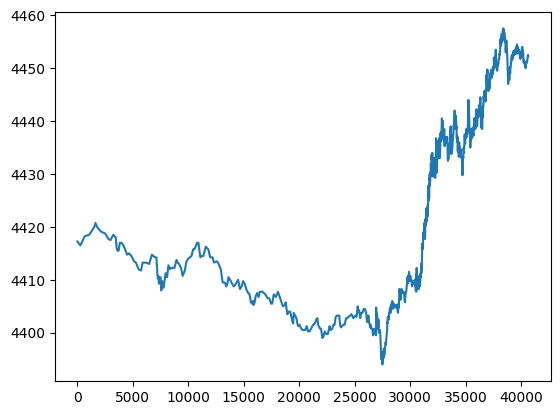

In [10]:
N=5600
N = 1500
X=X[:N]
tm = tm[:N]

plt.plot(tm,X)

In [11]:
tm_uniform = np.arange(tm[0], tm[-1], 1)
X_uniform = np.interp(tm_uniform, tm, X)
print(X_uniform.shape)
X_uniform = X_uniform.reshape(-1, 1)

(40655,)


In [12]:
# plt.plot(tm[:100], X[:100])
# plt.plot(tm_uniform[:5000], X_uniform[:5000])

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
X_uniform = scaler.fit_transform(X_uniform)
X_uniform

array([[0.36611933],
       [0.3660745 ],
       [0.36602967],
       ...,
       [0.91774939],
       [0.91756083],
       [0.91737227]])

In [14]:
train_size = int(len(X_uniform) * 0.75)
test_size = len(X_uniform) - train_size
train, test = X_uniform[:train_size,:], X_uniform[train_size:,:]

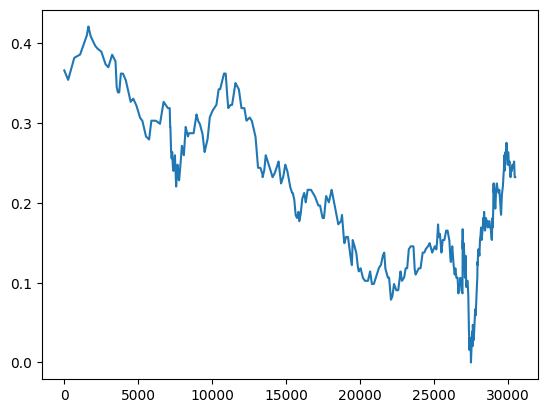

In [15]:
plt.plot(train)

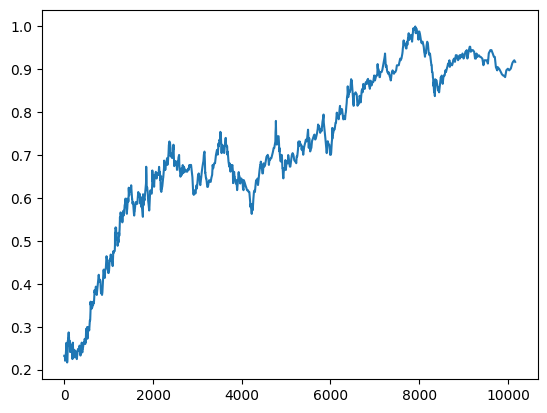

In [16]:
plt.plot(test)

In [17]:
def to_sequences(array, seq_size=1, fwd_intervals=[1]):
    x = []
    y = []
    offset_arr = np.array(fwd_intervals)-1
    last_minus = max(fwd_intervals)    
    for i in range(len(array)-1-seq_size-last_minus):
#         print(i)
        window = array[i:(i+seq_size), 0]
        x.append(window)
#         print(offset_arr+i)
        sl_arr = offset_arr + i
#         print(sl_arr)
        sub_arr = array[i + seq_size + offset_arr, 0]
#         print(window.shape)
        y.append(sub_arr)
        
    return np.array(x), np.array(y)
    

seq_size = 300  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
# fwd_intervals = [1, 60]
fwd_intervals = np.arange(1, 60)
fwd_size = len(fwd_intervals)

trainX, trainY = to_sequences(train, seq_size, fwd_intervals)
testX, testY = to_sequences(test, seq_size, fwd_intervals)

trainX = trainX.reshape((trainX.shape[0],  1, seq_size))
testX = testX.reshape((testX.shape[0],  1, seq_size))

trainX.shape, trainY.shape, testX.shape, testY.shape

((30131, 1, 300), (30131, 59), (9804, 1, 300), (9804, 59))

In [18]:
trainX.shape, trainY.shape
print("X:")
print(trainX[:10,:])
print("Y:")
print(trainY[:5, :])

X:
[[[0.36611933 0.3660745  0.36602967 ... 0.35658776 0.35665574 0.35672373]]

 [[0.3660745  0.36602967 0.36598484 ... 0.35665574 0.35672373 0.35679171]]

 [[0.36602967 0.36598484 0.36594001 ... 0.35672373 0.35679171 0.3568597 ]]

 ...

 [[0.36580551 0.36576068 0.36571585 ... 0.35706366 0.35713165 0.35719963]]

 [[0.36576068 0.36571585 0.36567102 ... 0.35713165 0.35719963 0.35726762]]

 [[0.36571585 0.36567102 0.36562619 ... 0.35719963 0.35726762 0.35733561]]]
Y:
[[0.35679171 0.3568597  0.35692769 0.35699567 0.35706366 0.35713165
  0.35719963 0.35726762 0.35733561 0.35740359 0.35747158 0.35753956
  0.35760755 0.35767554 0.35774352 0.35781151 0.3578795  0.35794748
  0.35801547 0.35808346 0.35815144 0.35821943 0.35828741 0.3583554
  0.35842339 0.35849137 0.35855936 0.35862735 0.35869533 0.35876332
  0.3588313  0.35889929 0.35896728 0.35903526 0.35910325 0.35917124
  0.35923922 0.35930721 0.3593752  0.35944318 0.35951117 0.35957915
  0.35964714 0.35971513 0.35978311 0.3598511  0.35991909 

In [19]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM, Flatten
# from keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Flatten
from tensorflow.keras.layers import ConvLSTM2D

In [20]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f"Gpus: {gpus}")
# tf.config.experimen

Gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1})
# config.gpu_options.per_process_gpu_memory_fraction = 0.8
# tf.compat.v1.InteractiveSession(config=config)

In [22]:
# # tf.config.experimental.set_virtual_device_configuration(
# #     gpus[0],
# #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])

# config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1})
# sess = tf.compat.v1.Session(config=config)
# # dir(sess)

In [23]:
model = Sequential()
model.add(LSTM(600, return_sequences=True, input_shape=(1, seq_size)))
model.add(LSTM(200))
model.add(Dense(50))
# model.add(Dense(120))
model.add(Dense(fwd_size, activation='linear'))
model.compile(optimizer='adam', loss='mae')

model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=True, epochs=500, batch_size=500)


Epoch 1/500
61/61 [==============================] - 6s 26ms/step - loss: 0.0440 - val_loss: 0.1140
Epoch 2/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0098 - val_loss: 0.1289
Epoch 3/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0069 - val_loss: 0.1314
Epoch 4/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0066 - val_loss: 0.1183
Epoch 5/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0067 - val_loss: 0.1162
Epoch 6/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0074 - val_loss: 0.1266
Epoch 7/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0067 - val_loss: 0.1360
Epoch 8/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0087 - val_loss: 0.1564
Epoch 9/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0056 - val_loss: 0.1271
Epoch 10/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0067 - val_loss: 0.1438

61/61 [==============================] - 1s 11ms/step - loss: 0.0057 - val_loss: 0.1167
Epoch 83/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.1077
Epoch 84/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0044 - val_loss: 0.1129
Epoch 85/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.1086
Epoch 86/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.1193
Epoch 87/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.1062
Epoch 88/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.1100
Epoch 89/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0050 - val_loss: 0.1234
Epoch 90/500
61/61 [==============================] - 1s 14ms/step - loss: 0.0046 - val_loss: 0.1156
Epoch 91/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.1132
Epo

61/61 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.1246
Epoch 163/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 0.1159
Epoch 164/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0.1241
Epoch 165/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 0.1190
Epoch 166/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0.1249
Epoch 167/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0054 - val_loss: 0.1406
Epoch 168/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.1505
Epoch 169/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0048 - val_loss: 0.1381
Epoch 170/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0038 - val_loss: 0.1234
Epoch 171/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0

61/61 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.1425
Epoch 243/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.1337
Epoch 244/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0042 - val_loss: 0.1369
Epoch 245/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.1376
Epoch 246/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0033 - val_loss: 0.1274
Epoch 247/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0046 - val_loss: 0.1534
Epoch 248/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0042 - val_loss: 0.1402
Epoch 249/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0038 - val_loss: 0.1326
Epoch 250/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.1305
Epoch 251/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0042 - val_loss: 0

61/61 [==============================] - 1s 11ms/step - loss: 0.0030 - val_loss: 0.1515
Epoch 323/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.1566
Epoch 324/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0041 - val_loss: 0.1597
Epoch 325/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.1453
Epoch 326/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 0.1522
Epoch 327/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.1502
Epoch 328/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.1462
Epoch 329/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.1509
Epoch 330/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.1493
Epoch 331/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0

61/61 [==============================] - 1s 13ms/step - loss: 0.0033 - val_loss: 0.1571
Epoch 403/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0.1590
Epoch 404/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.1545
Epoch 405/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0.1718
Epoch 406/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.1569
Epoch 407/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.1546
Epoch 408/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.1507
Epoch 409/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.1502
Epoch 410/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.1616
Epoch 411/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0028 - val_loss: 0

61/61 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.1617
Epoch 483/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.1589
Epoch 484/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0033 - val_loss: 0.1647
Epoch 485/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.1556
Epoch 486/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.1639
Epoch 487/500
61/61 [==============================] - 1s 11ms/step - loss: 0.0033 - val_loss: 0.1719
Epoch 488/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 0.1699
Epoch 489/500
61/61 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.1644
Epoch 490/500
61/61 [==============================] - 1s 13ms/step - loss: 0.0031 - val_loss: 0.1647
Epoch 491/500
61/61 [==============================] - 1s 13ms/step - loss: 0.0031 - val_loss: 0

In [24]:
# model = Sequential()
# model.add(LSTM(250, return_sequences=True, input_shape=(1,seq_size)))
# # model.add(LSTM(50))
# model.add(Dense(32))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict.shape, testPredict.shape

307/307 [==============================] - 1s 3ms/step


((30131, 59), (9804, 59))

In [26]:
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, fwd_size))
trainY = scaler.inverse_transform(trainY.reshape(-1, fwd_size))
testPredict = scaler.inverse_transform(testPredict.reshape(-1,fwd_size))
testY = scaler.inverse_transform(testY.reshape(-1, fwd_size))

trainPredict.shape, trainY.shape, testPredict.shape, testY.shape

((30131, 59), (30131, 59), (9804, 59), (9804, 59))

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [28]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

print()
trainScore = mean_absolute_error(trainY, trainPredict)
print('Train Score: %.2f ABE' % (trainScore))

testScore = mean_absolute_error(testY, testPredict)
print('Test Score: %.2f ABE' % (testScore))

Train Score: 0.30 RMSE
Test Score: 12.33 RMSE

Train Score: 0.19 ABE
Test Score: 10.57 ABE


In [29]:
print(testPredict.shape)

(9804, 59)


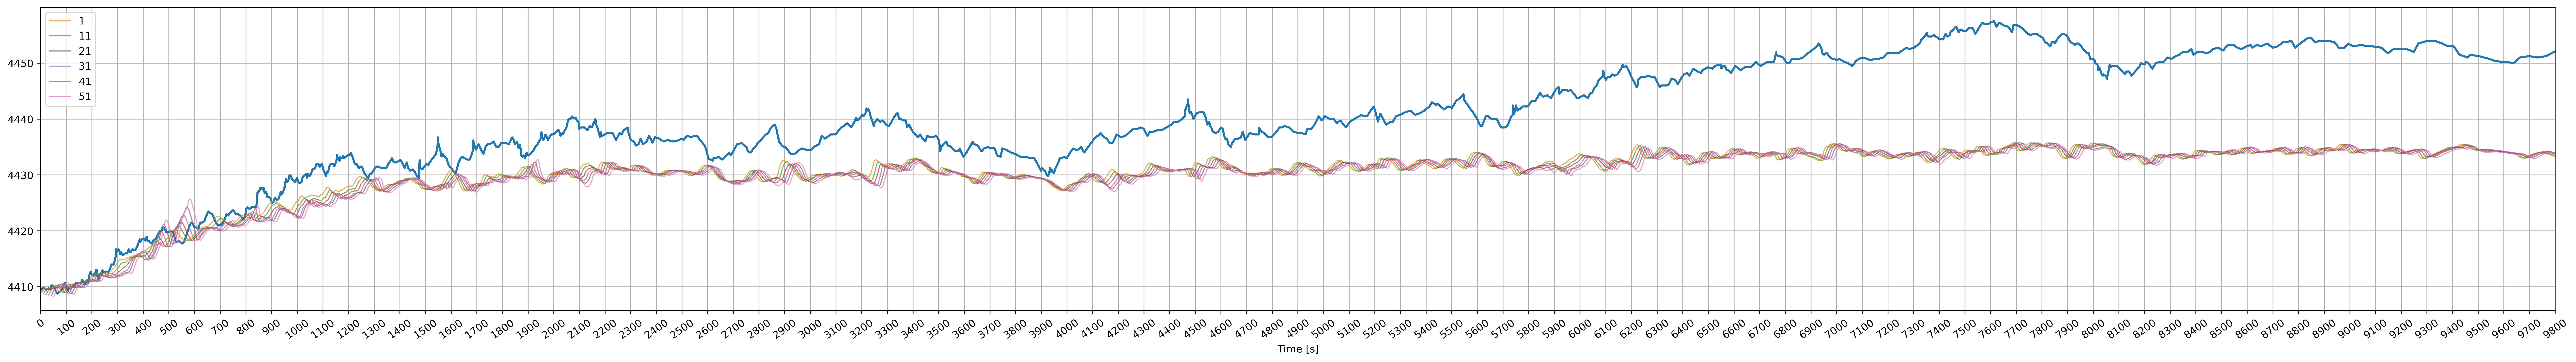

In [30]:
plt.figure(figsize=(35, 5), dpi=400)
plt.grid()
X = np.arange(len(testY))

plt.plot(X+1, testY[:,0], alpha=1, linewidth=2)
# plt.plot(X+60, testY[:,59], alpha=0.5, linewidth=1)
COLORS = [
    (0, 0.9, 0),
    (0, 0.7, 0.8),
    (0.9, 0, 0.6),
    (1, 0, 0),
    (0, 0, 0),    
]
for i, interv in enumerate(fwd_intervals):
    if not i%10:
        plt.plot(X+interv, testPredict[:, i], alpha=0.7, linewidth=1, label=interv)
    
# plt.plot(X+fwd_intervals[0], testPredict[:, 0], alpha=0.7, color=(0, 0.9, 0), linewidth=1, label='1')
# plt.plot(X+fwd_intervals[1], testPredict[:, 1], alpha=0.7, color=(0, 0.7, 0.8), linewidth=1, label='5')
# plt.plot(X+fwd_intervals[2], testPredict[:, 2], alpha=0.7, color=(0.9, 0, 0.6), linewidth=1, label='15')
# plt.plot(X+fwd_intervals[3], testPredict[:, 3], alpha=0.7, color=(1, 0, 0), linewidth=1, label='30')
# plt.plot(X+fwd_intervals[4], testPredict[:, 4], alpha=0.7, color=(0, 0, 0), linewidth=1, label='60')


plt.legend()
plt.xlabel('Time [s]')
plt.xlim([X[0], X[-1]])
ax = plt.gca()
ax.locator_params(axis='x', nbins=100)
plt.xticks(rotation=35)
plt.tight_layout()
fwd_str = '_'.join(str(num) for num in fwd_intervals)
plt.savefig(f"predict_{fwd_str}.png")

In [31]:
"Checking evaluation order"
print(testX.shape)

x1 = testX[0, :].reshape(1,1,-1)
x2 = testX[1, :].reshape(1,1,-1)
y1 = model.predict(x1)
y2 = model.predict(x2)
y3 = model.predict(x1)

print(y1[:,:5])
print(y2[:,:5])
print(y3[:,:5])

(9804, 1, 300)
1/1 [==============================] - 0s 21ms/step
[[0.234294   0.23413791 0.2338739  0.23372515 0.2337356 ]]
[[0.23515742 0.23500071 0.23478055 0.23463513 0.23466185]]
[[0.234294   0.23413791 0.2338739  0.23372515 0.2337356 ]]
